# Spatial Analysis
This notebook analyzes trends in high-magnitude flow (HMF) metrics using PCA, k-means cluster analysis

In [1]:
# Import packages
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload
import mapclassify as mc
from dataretrieval import nwis

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

C:\Users\kondr\anaconda3\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.7.0-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

## Import valid streamgages and US shapefiles

In [2]:
# Dataset upload
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/Station_names/National_Metrics_50_95.xlsx'    
}

#dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}
dfs_valid = {key: pd.read_excel(path) for key, path in data_paths.items()}

In [3]:
# Number of valid gages
date_ranges = ['30', '50']
percentiles = ['90', '95']
for date_range in date_ranges:
    for percentile in percentiles: 
        df_length = dfs_valid[f'{date_range}_{percentile}']
        print(f'{date_range}-Year gages (valid = True): {len(df_length)}')

30-Year gages (valid = True): 4242
30-Year gages (valid = True): 4242
50-Year gages (valid = True): 3314
50-Year gages (valid = True): 3314


In [4]:
# US states, aquifers, and HUC2s to plot
lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
aq_usgs = gpd.read_file('ShapeFiles/Aquifers_USGS/us_aquifers.shp')
stream_network = gpd.read_file('ShapeFiles/Streams_US/us_streams.shp')
#stream_network_detailed = gpd.read_file('ShapeFiles/Streams_US/us_streams_detailed.shp')
aq_usgs_selected_10 = gpd.read_file('ShapeFiles/Aquifers_USGS_10/Aquifers_USGS_10.shp')
aq_usgs_selected_25 = gpd.read_file('ShapeFiles/Aquifers_USGS_25/Aquifers_USGS_25.shp')
huc2 = gpd.read_file('ShapeFiles/_Master_HUC2/master_huc2.shx')

In [72]:
dfs_valid['30_90'].columns

Index(['Unnamed: 0', 'site_no', 'analyze_start', 'analyze_end',
       'analyze_range', 'quantile', 'valid', 'missing_data%', 'threshold',
       'hmf_years', 'annual_hmf', 'six_mo_hmf', 'three_mo_hmf',
       'annual_duration', 'event_duration', 'event_hmf', 'inter_annual%',
       'intra_annual', 'timing', 'jan_hmf', 'feb_hmf', 'mar_hmf', 'apr_hmf',
       'may_hmf', 'jun_hmf', 'jul_hmf', 'aug_hmf', 'sep_hmf', 'oct_hmf',
       'nov_hmf', 'dec_hmf', 'dec_lat_va', 'dec_long_va', 'data_start',
       'data_end', 'total_record', 'state', 'huc2_code', 'huc4_code',
       'within_aq', 'HCDN_2009', 'station_nm'],
      dtype='object')

## K-means clustering

In [5]:
import sklearn
from sklearn.cluster import KMeans

In [20]:
# Controls
df = dfs_valid['30_90']
plot_huc2 = False
plot_aq_10 = True
n_clusters = 4

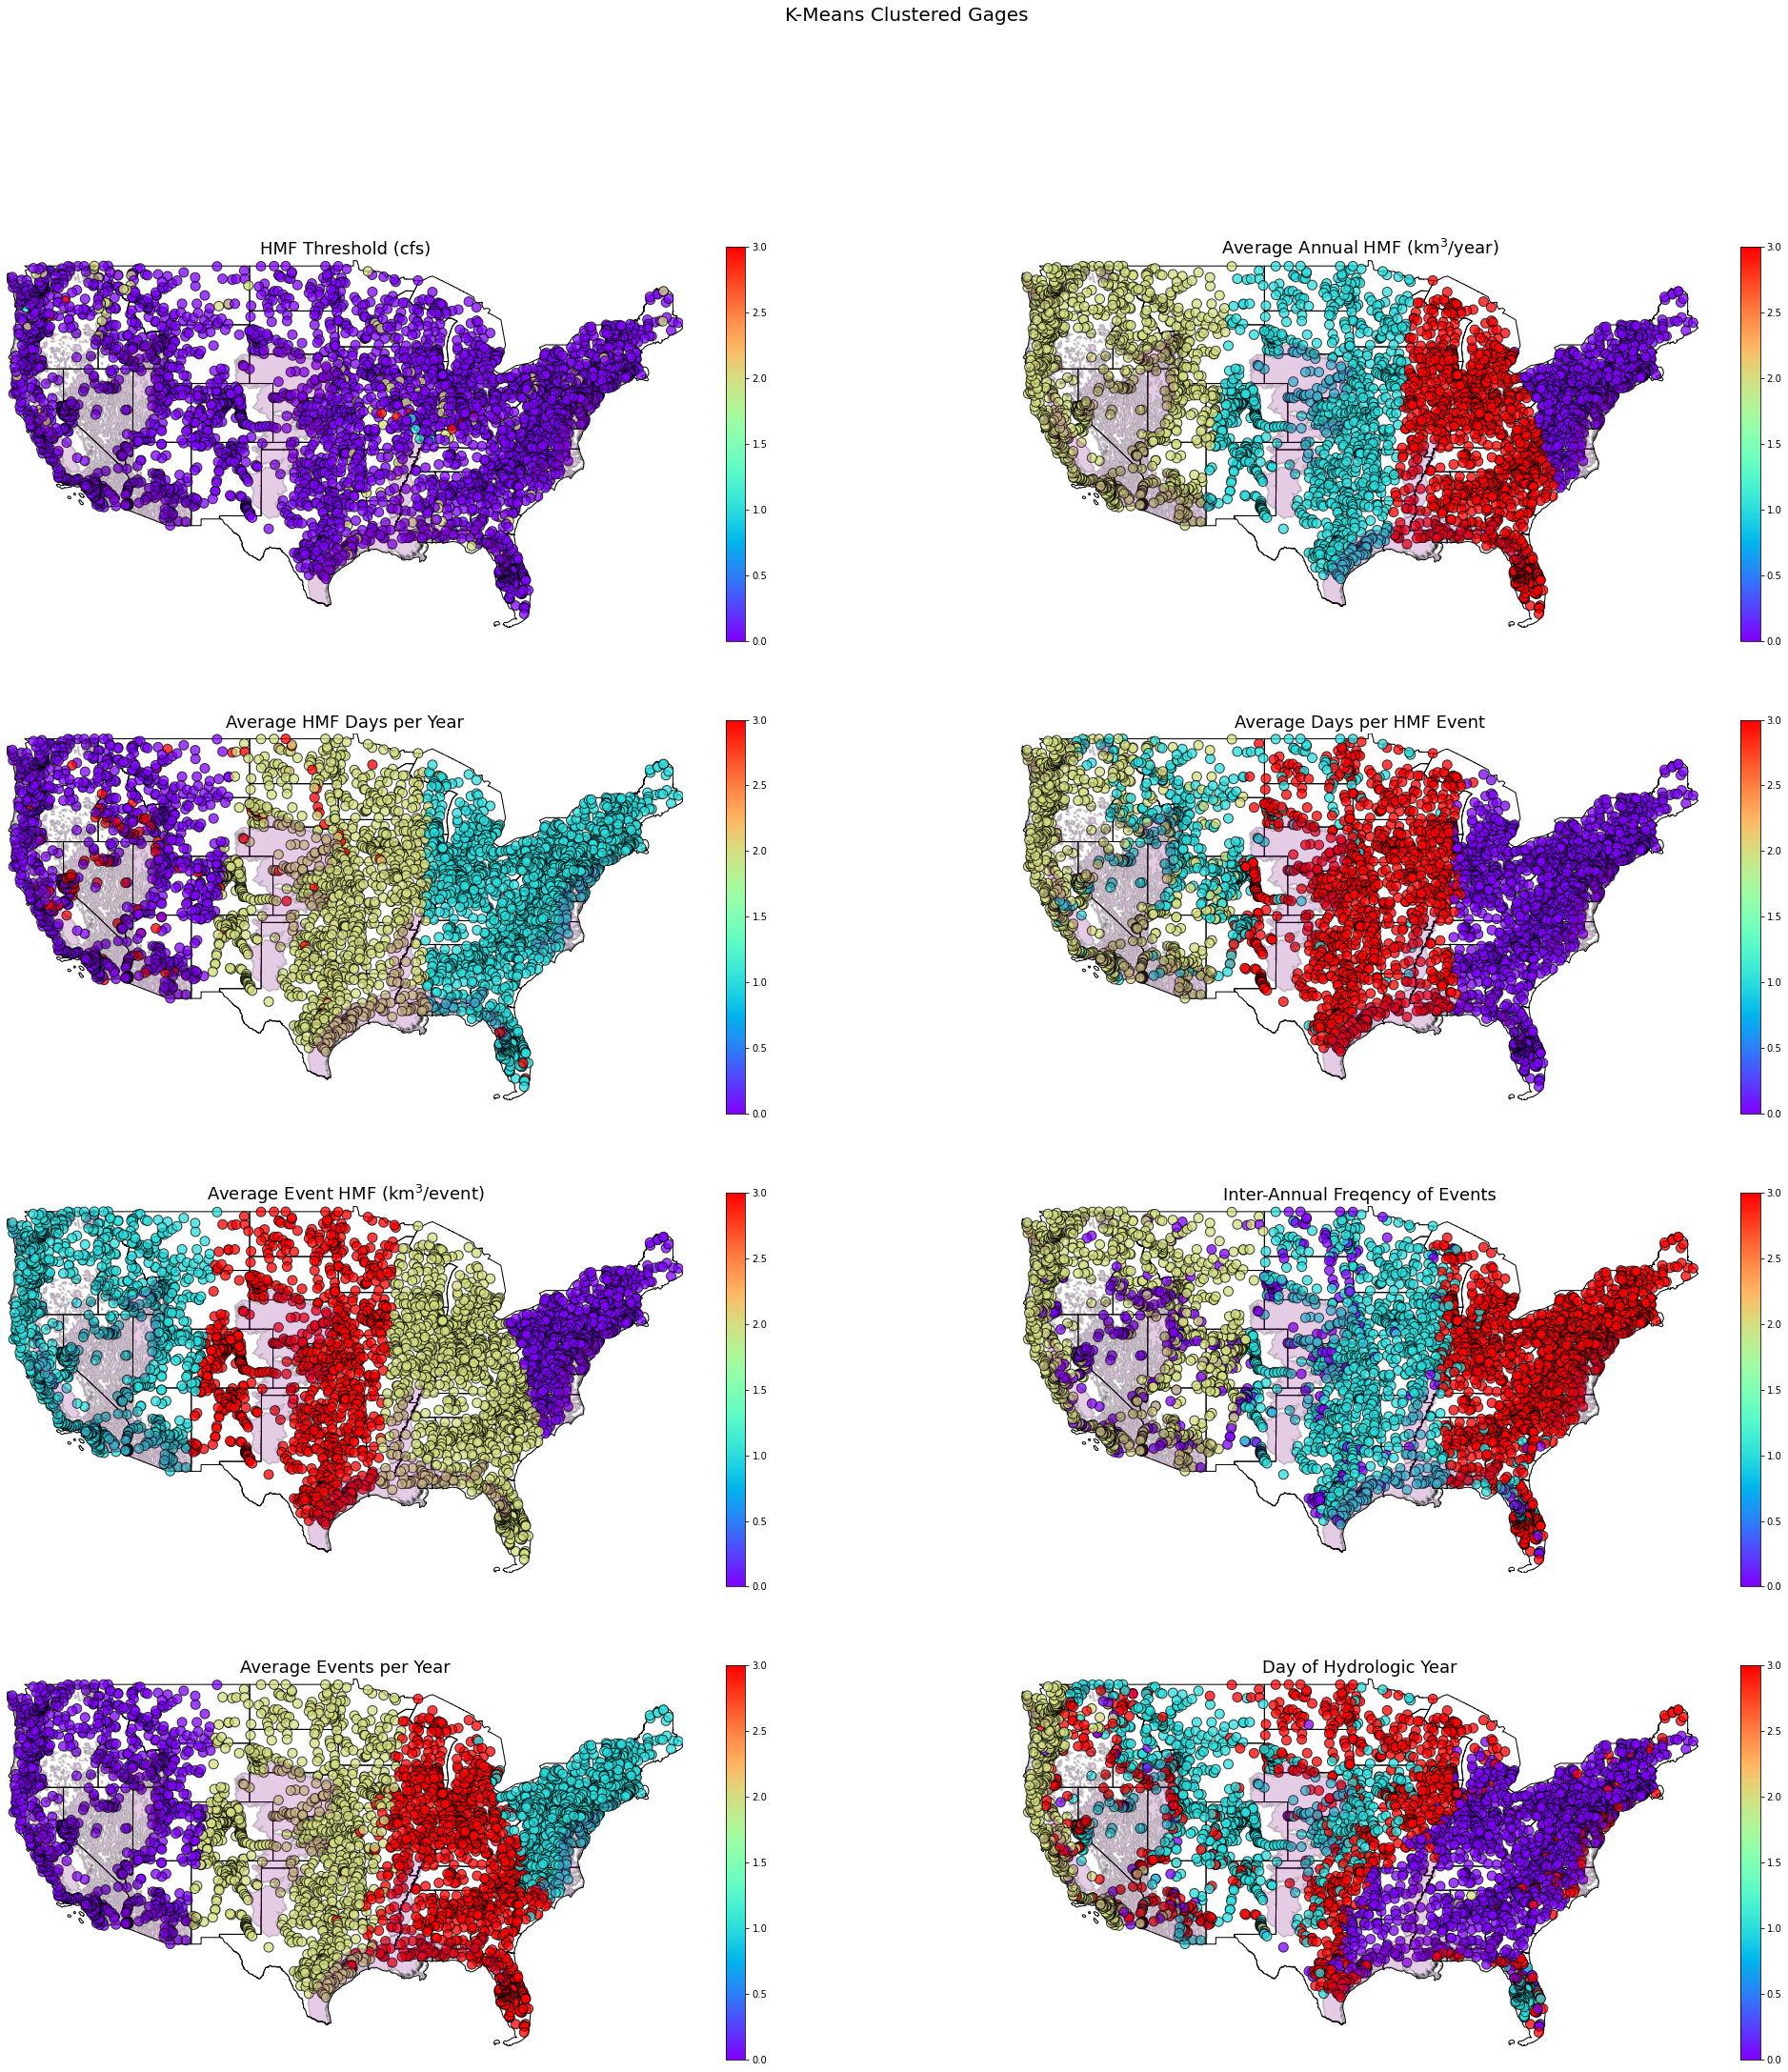

In [53]:
metric_list = ['threshold', 'annual_hmf', 'annual_duration', 'event_duration', 'event_hmf', 'inter_annual%', 'intra_annual', 'timing']

def kmeans_clusters_map(df, metric_list, lower48, huc2, aq_usgs_selected_10, n_clusters):
    i = 0
    j = 0
    k = 0
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(35, 35))
    for metric in metric_list:
        X = df[['dec_lat_va', 'dec_long_va', metric]]
        #print(X)

        # Specify the number of clusters
        kmeans = KMeans(n_clusters=n_clusters)

        # Fit the data to the algorithm
        kmeans.fit(X)

        # Get the cluster centroids and labels
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_

        identified_clusters = kmeans.fit_predict(X)

        df['Clusters'] = labels

        # Set counter for axes
        if k in [2, 3]:
            i = 1
            j = k - 2
        elif k in [4, 5]:
            i = 2
            j = k - 4
        elif k in [6, 7]:
            i = 3
            j = k - 6
        else:
            pass

        plt.suptitle(f'K-Means Clustered Gages', fontsize=20)
        ax[i,j].set_title(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=18)

        lower48 = lower48.to_crs(epsg=4269)
        #lower48 = lower48.to_crs('ESRI:102003')
        lower48.plot(ax=ax[i,j], edgecolor='black', facecolor='none', linewidth=1.0) 

        #stream_network.plot(ax=ax, color='blue', linewidth=1.5, alpha=0.8, zorder=2) 

        lat = df['dec_lat_va'].tolist()
        long = df['dec_long_va'].tolist()
        geometry = [Point(xy) for xy in zip(long, lat)]
        df['geometry'] = geometry
        geo_df = gpd.GeoDataFrame(df, crs=4269, geometry=geometry)

        bx = geo_df.plot(ax=ax[i,j], column='Clusters', cmap='rainbow', marker='o', markersize=100, 
                             edgecolor='black', linewidth=1, alpha=0.75, legend=True) 

        if plot_huc2 == True:
            huc2 = huc2.to_crs(epsg=4269)
            huc2.plot(ax=ax[i,j], edgecolor='black', facecolor='none', linewidth=3.0) 

        if plot_aq_10 == True:
            aq_usgs_selected_10 = aq_usgs_selected_10.to_crs(epsg=4269)
            aq_usgs_selected_10.plot(ax=ax[i,j], edgecolor='black', facecolor='purple', linewidth=1.5, alpha=0.2)

        ax[i,j].margins(0, tight=True)
        ax[i,j].set_axis_off()
        
        j += 1
        k += 1
        

    plt.show()
    return
    
kmeans_clusters_map(df, metric_list, lower48, huc2, aq_usgs_selected_10, n_clusters)

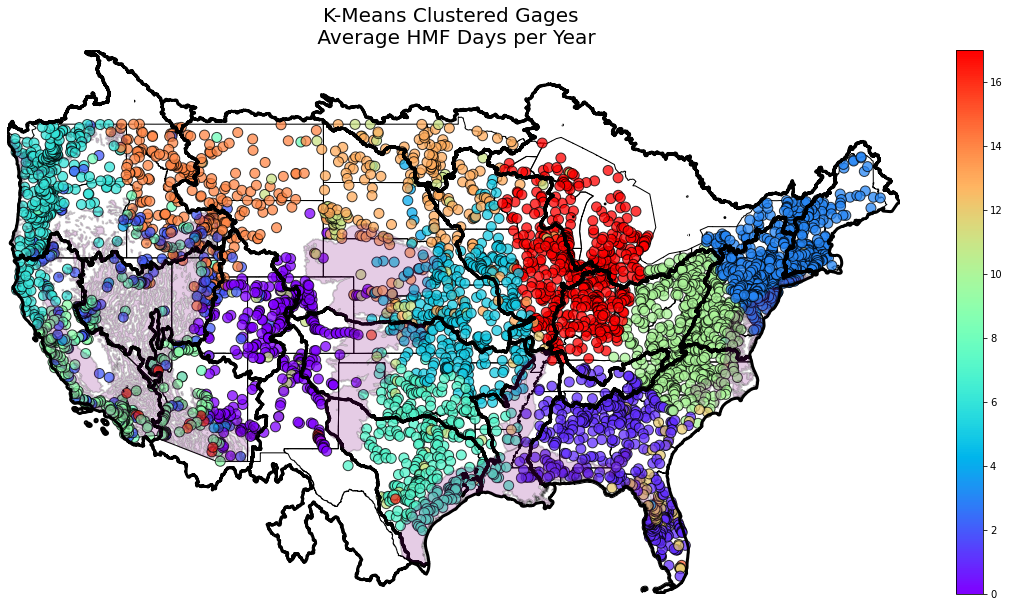

In [81]:
metric_list = ['threshold', 'annual_hmf', 'annual_duration', 'event_duration', 'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
metric = 'annual_duration'
plot_huc2 = True
plot_aq_10 = True
n_clusters = 18

def kmeans_clusters_map(df, metric, lower48, huc2, aq_usgs_selected_10, n_clusters):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    X = df[['dec_lat_va', 'dec_long_va', metric]]
    #print(X)

    # Specify the number of clusters
    kmeans = KMeans(n_clusters=n_clusters)

    # Fit the data to the algorithm
    kmeans.fit(X)

    # Get the cluster centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    #identified_clusters = kmeans.fit_predict(X)

    df['Clusters'] = labels

    plt.title(f'K-Means Clustered Gages \n {fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)

    lower48 = lower48.to_crs(epsg=4269)
    #lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.0) 

    #stream_network.plot(ax=ax, color='blue', linewidth=1.5, alpha=0.8, zorder=2) 

    lat = df['dec_lat_va'].tolist()
    long = df['dec_long_va'].tolist()
    geometry = [Point(xy) for xy in zip(long, lat)]
    df['geometry'] = geometry
    geo_df = gpd.GeoDataFrame(df, crs=4269, geometry=geometry)

    bx = geo_df.plot(ax=ax, column='Clusters', cmap='rainbow', marker='o', markersize=100, 
                         edgecolor='black', linewidth=1, alpha=0.75, legend=True, legend_kwds={"shrink":.5}) 

    if plot_huc2 == True:
        huc2 = huc2.to_crs(epsg=4269)
        huc2.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=3.0) 

    if plot_aq_10 == True:
        aq_usgs_selected_10 = aq_usgs_selected_10.to_crs(epsg=4269)
        aq_usgs_selected_10.plot(ax=ax, edgecolor='black', facecolor='purple', linewidth=1.5, alpha=0.2)

    ax.margins(0, tight=True)
    ax.set_axis_off()
        

    plt.show()
    return
    
kmeans_clusters_map(df, metric, lower48, huc2, aq_usgs_selected_10, n_clusters)

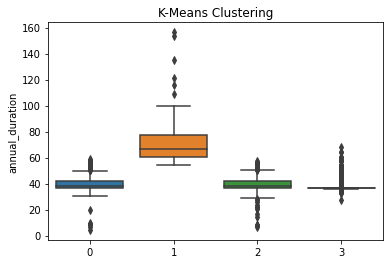

In [73]:
# Distribution of distinct groups
metric = 'annual_duration'
n_clusters = 4
X = df[['dec_lat_va', 'dec_long_va', metric]]

# Specify the number of clusters
kmeans = KMeans(n_clusters=n_clusters)

# Fit the data to the algorithm
kmeans.fit(X)

# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

sns.boxplot(x = kmeans.labels_, y = df[metric]).set(title='K-Means Clustering')
plt.show()

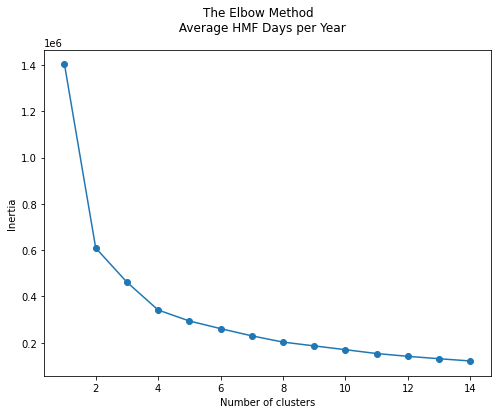

In [64]:
def elbow_method(df, metric):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    X = df[['dec_lat_va', 'dec_long_va', metric]]
    #print(X)

    # Specify the number of clusters
    kmeans = KMeans(n_clusters=6)

    # Fit the data to the algorithm
    kmeans.fit(X)

    # Save interias
    intertias = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(X)
        intertias.append(kmeans.inertia_)

    number_clusters = range(1,15)
    plt.plot(number_clusters, intertias, marker='o')
    plt.suptitle(f'The Elbow Method \n {fn.FLOW_METRIC_UNITS[metric]}', fontsize=12)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
        
    plt.show()
    return

elbow_method(df, metric)

## Hierarchical Clustering

In [60]:
# Specify the data
metric = 'annual_duration'
X = df[['dec_lat_va', 'dec_long_va', metric]]

# Rescale the data
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(X)

(4242, 3)

In [61]:
# Apply clustering
from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(scaled_data, method="complete", metric="euclidean")
average_clustering = linkage(scaled_data, method="average", metric="euclidean")
single_clustering = linkage(scaled_data, method="single", metric="euclidean")

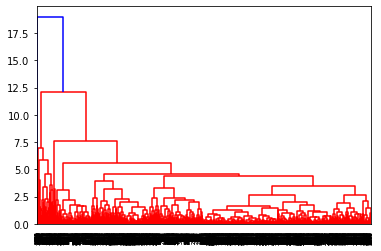

In [62]:
dendrogram(complete_clustering)
plt.show()

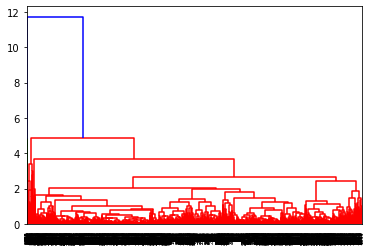

In [63]:
dendrogram(average_clustering)
plt.show()

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


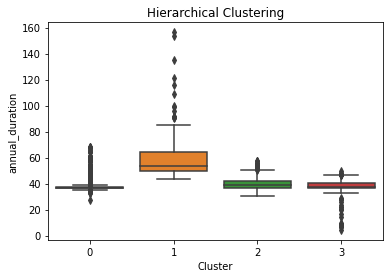

In [74]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_labels = hierarchical_cluster.fit_predict(X)

X["Cluster"] = cluster_labels

sns.boxplot(x=X['Cluster'], y=X[metric]).set(title='Hierarchical Clustering')
plt.show()

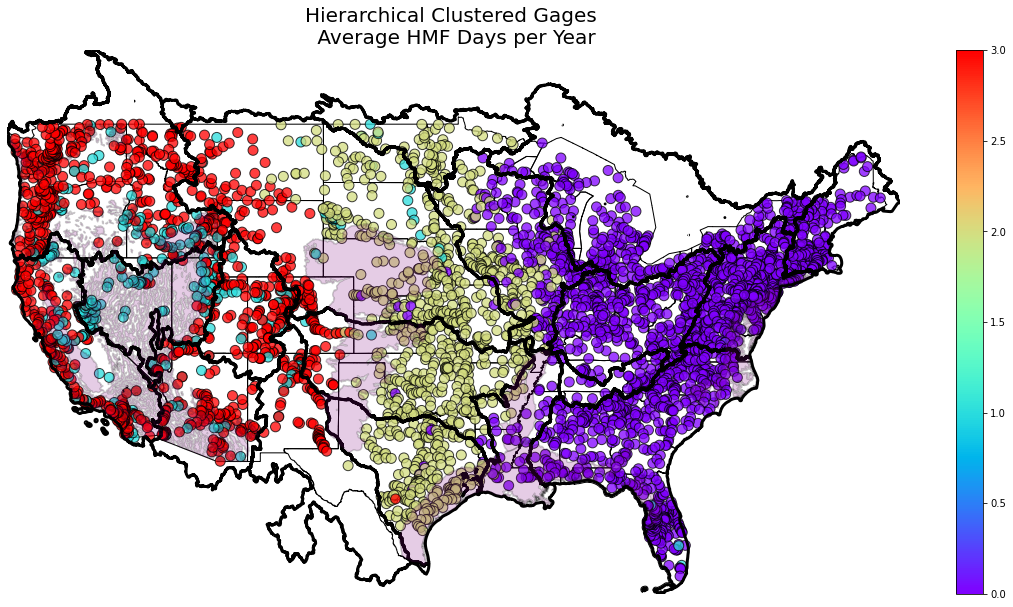

In [78]:
metric_list = ['threshold', 'annual_hmf', 'annual_duration', 'event_duration', 'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
metric = 'annual_duration'
plot_huc2 = True
plot_aq_10 = True
n_clusters = 4

def hierarch_clusters_map(df, metric, lower48, huc2, aq_usgs_selected_10, n_clusters):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    X = df[['dec_lat_va', 'dec_long_va', metric]]
    #print(X)

    # Scale data
    data_scaler = StandardScaler()
    scaled_data = data_scaler.fit_transform(X)

    # Fit the data to the tree
    average_clustering = linkage(scaled_data, method="average", metric="euclidean")

    # Get the cluster centroids and labels
    hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    cluster_labels = hierarchical_cluster.fit_predict(X)

    df['Clusters'] = cluster_labels

    plt.title(f'Hierarchical Clustered Gages \n {fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)

    lower48 = lower48.to_crs(epsg=4269)
    #lower48 = lower48.to_crs('ESRI:102003')
    lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.0) 

    #stream_network.plot(ax=ax, color='blue', linewidth=1.5, alpha=0.8, zorder=2) 

    lat = df['dec_lat_va'].tolist()
    long = df['dec_long_va'].tolist()
    geometry = [Point(xy) for xy in zip(long, lat)]
    df['geometry'] = geometry
    geo_df = gpd.GeoDataFrame(df, crs=4269, geometry=geometry)

    bx = geo_df.plot(ax=ax, column='Clusters', cmap='rainbow', marker='o', markersize=100, 
                         edgecolor='black', linewidth=1, alpha=0.75, legend=True, legend_kwds={"shrink":.5}) 

    if plot_huc2 == True:
        huc2 = huc2.to_crs(epsg=4269)
        huc2.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=3.0) 

    if plot_aq_10 == True:
        aq_usgs_selected_10 = aq_usgs_selected_10.to_crs(epsg=4269)
        aq_usgs_selected_10.plot(ax=ax, edgecolor='black', facecolor='purple', linewidth=1.5, alpha=0.2)

    ax.margins(0, tight=True)
    ax.set_axis_off()
        

    plt.show()
    return
    
hierarch_clusters_map(df, metric, lower48, huc2, aq_usgs_selected_10, n_clusters)